Questions
<br>🔹 Who is an active vs. inactive patient? <br>🔹 Are high-value patients leaving? <br>🔹 Which patient segments need retention efforts?

Datasets
<br>🔹 All Patient Details <br>🔹 Active Patient Details <br>🔹 Incurred Charges <br>🔹 Guarantor Payments

# Active vs. Inactive Patient Analysis (Attrition Risk) <br>
📌 Goal: Identify patients who haven't returned & optimize outreach efforts.<br>
✅ Steps:<br>

Compare active vs. inactive patient lists (who hasn’t visited in 12-24 months?).<br>
Segment patients by treatment history, insurance plan, visit frequency.<br>
Rank patient segments by retention risk (likelihood to never return).<br>
✅ Datasets Used:<br>
All Patient Details, Active Patient Details, Incurred Charges<br>
📌 Business Impact:<br>
🚀 Enables targeted retention campaigns.<br>
🚀 Reduces lost revenue from patient churn.<br>

In [60]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
from collections import defaultdict
import re
import Levenshtein
from itertools import combinations
from scipy.stats import gmean
import profiler as pf
import math

os.chdir('C:/Users/Admin/Documents/GitHub/Data-Guide')

In [3]:
pull_date = pd.to_datetime('2025-02-18')

In [ ]:
procedure_map = {
    "Crowns": [
        "Crown - 3/4 porcelain/ceramic", "Full Cast HNM Crown", "Full Porcelain/Ceramic Crown",
        "Implant supported crown - porcelain fused to high noble alloys",
        "Porcelain/HNM Crown", "Porcelain/HNM Pontic", "Porcelain/Noble Crown",
        "Retainer crown - porcelain fused to high noble metal", "Re-cement or re-bond crown", 
        "Core Buildup w/ Any Pins",
    ],
    
    "Prophies": ["Prophylaxis - Adult", "Prophylaxis - Child", "Topical Applic Fluoride Varnish", 
        "Topical Application of Fluoride", "Sealant", "StellaLife Gel", "StellaLife Rinse"],
    
    "Fillings": [
        "Anterior Resin Composite 1s", "Anterior Resin Composite 2s", "Anterior Resin Composite 3s", 
        "Anterior Resin Composite 4+s", "Posterior Resin Composite 1s", "Posterior Resin Composite 2s", 
        "Posterior Resin Composite 3s", "Posterior Resin Composite 4+s",
        "Custom Abutment"
    ],
    
    "Imaging": [
        "2D Oral/Facial Photo Images", "Bitewing Four Images", "Bitewing Single Image", "Bitewing Two Images",
        "Intraoral - comprehensive series of radiographic images", "Intraoral Periapical Add'l", 
        "Intraoral Periapical Images", "Panoramic Image", "Intraoral – comprehensive series of radiographic images"
    ],
    
    "Evaluations": [
        "Comprehensive Evaluation", "Periodic Evaluation", "Limited Evaluation", "Re-eval - Post-op Office Visit",
        "Periodontal Evaluation"
    ],
    
    "SRP": ["Scaling & Root Planing (1-3)", "Scaling & Root Planing (4-8)", "Scaling in presence of generalized gingival inflammation, full mouth"],
    
    "Perio Maintenance": ["Periodontal Maintenance"],
    
    "Appliance": [
        "Occlusal guard - hard appliance, full arch", "Orthodontic Retention", 
        "Replacement of lost or broken retainer - mandibular", "Re-cement or re-bond fixed retainer - maxillary",
        "Recement/bnd inlay/onlay/part", "Recemnt/bnd cast/prefab pst/cor"
    ],
    
    "Other": [
        "Bone Replacement Graft", "Palliative treatment of dental pain - per visit",
        "Removal of fixed orthodontic appliances for reasons other than completion of treatment",
        "Cancelled Appointment", "Late cancellation fee", "Teeth White - In Office", "Teeth White - Take Home",
        "Diagnostic/Study Models", "Editorial change to the descriptor", 
        "Misc Invoice", "Routine Extraction", 
        "Remove Coronal Remnants - primary tooth", "Limited Occlusal Adjustment",
        "External Bleaching-Office-Arch"
    ],

    "Dental Wellness Plan": ["Dental Wellness Plan"],
    
    "Dentures & Partials": [
        "Interim Lower Partial Denture", "Interim Upper Partial Denture", "Lower Partial w/ Resin Base"
    ],
}

In [164]:
input_dir = "C:/Users/Admin/Documents/GitHub/Data-Guide/data_pipeline/transformed_feb_18" 

output_dir = "C:/Users/Admin/Documents/GitHub/Data-Guide/data_pipeline/analyses_feb_18"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the data
csv_files = {
    #"aged_AR" : os.path.join(input_dir, "transformed_aged_AR.csv"),
    #"aged_AR_long" : os.path.join(input_dir, "transformed_aged_AR_long.csv"),
    #"statement_submission" : os.path.join(input_dir, "transformed_statement_submission.csv"),
    #"integrated_payments" : os.path.join(input_dir, "transformed_integrated_payments.csv"),
    #"billing_statement" : os.path.join(input_dir, "billing_statement_report.csv"),
    #"outstanding_claims" : os.path.join(input_dir, "transformed_outstanding_claims.csv"),
    # "unresolved_claims" : os.path.join(input_dir, "unresolved_claims_report.csv"),
    #"fee_schedule" : os.path.join(input_dir, "fee_schedule.csv"),
    #"openings" : os.path.join(input_dir,"openings.csv"),
    #"schedule" : os.path.join(input_dir,"schedule.csv"),
    "patient_details" : os.path.join(input_dir, "transformed_patient_details.csv"),
    "active_patients" : os.path.join(input_dir, "transformed_active_patient_details.csv"),
    #"processed_payments": os.path.join(input_dir, "transformed_processed_payments.csv"),
    #"payments": os.path.join(input_dir, "transformed_payments.csv"),
    "incurred_charges": os.path.join(input_dir, "transformed_incurred_charges.csv"),
    "transaction_details" : os.path.join(input_dir, "transformed_transaction_details.csv"),
    # "treatment_tracker" : os.path.join(input_dir, "ZR - Treatment Tracker.csv"),
    # "merged_data" : os.path.join(input_dir, "merged_data.csv"),
    #'carrier_decision_data' : os.path.join(input_dir, 'Carrier_Decision_Data.csv'),
    #'insurance_payment_metrics' : os.path.join(input_dir, 'insurance_payment_metrics.csv'),
    "financial_timeline" : os.path.join(input_dir, "financial_timeline.csv"),
    #'time_to_payments' : os.path.join(input_dir, "time_to_payments.csv"),
}
 # Load datasets
dataframes = {dataset: pd.read_csv(file_path) for dataset, file_path in csv_files.items()}

# Markov Model

In [165]:
transactions = dataframes['transaction_details']
transactions.head(30)

,Date,Patient,Ascend Patient ID,Chart Number,Category,Proc. Code,Proc. Description,Proc Treatment Area,Charges,Credits,...,palliative,late,cancellation,orthodontic,extraction,posterior,anterior,panoramic,radiographic,Referral
0,10/27/2019,"Gabriel, Rami",14000002286456,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,06/21/2020,"Barrios, James",14000002286515,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,47.2,0.0,...,False,False,False,False,False,False,False,False,False,False
2,10/08/2020,"Greene, David E",14000002286843,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,10/08/2020,"Koenig, Cody",14000002286781,CK5152H,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,10/20/2020,"Reiman, Stephanie M",14000002286454,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
5,10/22/2020,"Giles-spencer, Diane",14000002286826,Not Available,Procedures,D0180,Periodontal Evaluation,Mouth,134.0,0.0,...,False,False,False,False,False,False,False,False,False,False
6,10/22/2020,"Giles-spencer, Diane",14000002286826,Not Available,Procedures,D0210,Intraoral – comprehensive series of radiograph...,NaN,180.0,0.0,...,False,False,False,False,False,False,False,False,True,False
7,10/27/2020,"Gabriel, Rami",14000002286456,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
8,11/03/2020,"Tolinski, Ross J",14000002286777,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
9,11/10/2020,"Pettengill, Jacob",14000002286723,Not Available,Charge Adjustments,Not Available: spaces etc.,Not Available: spaces etc.,NaN,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
procedure_timeline = transactions.loc[transactions['Category'] == 'Procedures',
                                    ["Ascend Patient ID", "Category", 'Date', 'Proc. Description', 'Proc Treatment Area', 'Charges']
                                    ].melt(id_vars=["Ascend Patient ID", "Category", 'Date', 'Proc. Description', 'Proc Treatment Area'],
                                            var_name="Var", 
                                            value_name="Value"
                                            ).drop(axis=1, columns=['Var']
                                            ).sort_values(["Ascend Patient ID", 'Date']
                                                        ).query('Value != 0'
                                                                ).groupby(["Ascend Patient ID", "Category", 'Date', 'Proc. Description']
                                                                            ).agg({
                                                                                "Proc Treatment Area": [
                                                                                    ("Number of Treatment Areas", lambda x: x.nunique()),
                                                                                    ("Treatment Areas", lambda x: ", ".join(x.dropna()))
                                                                                    ],
                                                                                "Value": [
                                                                                    ("Value", lambda x: x.sum())
                                                                                    ]
                                                                                    }).reset_index()

In [167]:
procedure_timeline.columns = procedure_timeline.columns.map(lambda x: x[1] if x[1] != '' else x[0])

In [168]:
procedure_timeline.head(30)

,Ascend Patient ID,Category,Date,Proc. Description,Number of Treatment Areas,Treatment Areas,Value
0,14000002286402,Procedures,01/02/2024,Periodic Evaluation,1,Mouth,72.0
1,14000002286402,Procedures,01/02/2024,Prophylaxis - Adult,1,Mouth,125.0
2,14000002286402,Procedures,02/03/2025,Periodic Evaluation,1,Mouth,80.0
3,14000002286402,Procedures,02/03/2025,Prophylaxis - Adult,1,Mouth,138.0
4,14000002286402,Procedures,02/03/2025,Topical Applic Fluoride Varnish,1,Mouth,62.0
5,14000002286402,Procedures,04/20/2022,Periodic Evaluation,0,,72.0
6,14000002286402,Procedures,04/20/2022,Prophylaxis - Adult,0,,125.0
7,14000002286402,Procedures,07/05/2024,Bitewing Four Images,1,Mouth,91.0
8,14000002286402,Procedures,07/05/2024,Intraoral Periapical Add'l,1,"Th23, Th24, Th25, Th26",35.0
9,14000002286402,Procedures,07/05/2024,Intraoral Periapical Images,1,"Th7, Th8, Th9, Th10",41.0


In [169]:
procedure_timeline["proc_group"] = procedure_timeline["Proc. Description"].apply(lambda x: next((k for k, v in procedure_map.items() if x in v), "Other"))

In [170]:
procedure_timeline.groupby(['proc_group']).agg({
    'Value': ['sum', 'count']
}).sort_values(('Value', 'sum'), ascending=False)

Value      
                            sum count
proc_group                           
Crowns                579713.00   522
Fillings              569379.00  1503
Prophies              378494.10  3131
Imaging               370687.00  4690
Evaluations           306788.00  3375
SRP                   111886.00   217
Appliance              74319.25   128
Perio Maintenance      50943.00   248
Other                  32231.60   149
Dental Wellness Plan   27400.00    60
Dentures & Partials     6382.00     8

In [171]:
procedure_timeline.loc[procedure_timeline['proc_group'] == 'Other', 'Proc. Description'].unique()

array(['Extraction of Erupted Tooth with Bone Removal',
       'Teeth White - In Office', 'Routine Extraction',
       'Late cancellation fee', 'Editorial change to the descriptor',
       'Diagnostic/Study Models',
       'Re-cement or re-bond fixed retainer – maxillary',
       'Replacement of lost or broken retainer – mandibular',
       'Teeth White - Take Home', 'Other Drugs/Medicaments',
       'Remove Coronal Remnants - primary tooth', 'Misc Invoice',
       'Bone Replacement Graft',
       'Palliative treatment of dental pain – per visit',
       'Limited Occlusal Adjustment', 'External Bleaching-Office-Arch',
       'Cancelled Appointment',
       'Removal of fixed orthodontic appliances for reasons other than completion of treatment',
       'Recement/bnd imp/abut sup crwn', 'Desensitizing Medicament'],
      dtype=object)

In [172]:
procedure_timeline.loc[procedure_timeline['proc_group'] == 'Other'].groupby(['Proc. Description']).agg({
    'Value': ['sum', 'count']
}).sort_values(('Value', 'sum'), ascending=False)

Value      
                                                       sum count
Proc. Description                                               
Teeth White - In Office                             8518.0    20
Routine Extraction                                  8072.6    25
Extraction of Erupted Tooth with Bone Removal       4148.0    11
Teeth White - Take Home                             2266.5    21
Palliative treatment of dental pain – per visit     2073.0    12
Bone Replacement Graft                              1802.0     2
Late cancellation fee                                912.9    17
Replacement of lost or broken retainer – mandib...   600.0     1
Removal of fixed orthodontic appliances for rea...   572.0     2
Remove Coronal Remnants - primary tooth              561.0     2
Other Drugs/Medicaments                              537.0    17
Limited Occlusal Adjustment                          534.0     2
Re-cement or re-bond fixed retainer – maxillary      464.0     2
External Bleaching-Office-Arch                       435.0     1
Recement/bnd imp/abut sup crwn                       213.0     1
Diagnostic/Study Models                              176.0     1
Editorial change to the descriptor                   135.0     9
Desensitizing Medicament                              84.0     1
Cancelled Appointment                                 75.0     1
Misc Invoice                                          52.6     1

In [173]:
state_space = procedure_timeline.groupby(['Ascend Patient ID', 'Date']).agg({
    'Value': [('Total Charges','sum')],
    "Proc. Description": [
        ("Number of Procedures", "count"),
        ("Number Distinct Procedures", "nunique"),
        ("Procedures", lambda x: ", ".join(x))
    ],
    "proc_group": [
        ("Number of Proc Groups", "nunique"),
        ("Groups", lambda x: ", ".join(sorted(pd.unique(x))))
    ]
}).reset_index()

In [174]:
state_space.columns = state_space.columns.map(lambda x: x[1] if x[1] != '' else x[0])
state_space['Date'] = pd.to_datetime(state_space['Date'])

state_space = state_space.sort_values(['Ascend Patient ID', 'Date'], ascending=True)

In [175]:
state_space["Prior Groups"] = state_space.groupby("Ascend Patient ID")["Groups"].shift(1)
state_space["Next Groups"] = state_space.groupby("Ascend Patient ID")["Groups"].shift(-1)

state_space["Prior Date"] = state_space.groupby("Ascend Patient ID")["Date"].shift(1)
state_space["Next Date"] = state_space.groupby("Ascend Patient ID")["Date"].shift(-1)

state_space["Days Since Prior"] = (state_space["Date"] - state_space["Prior Date"]).dt.days
state_space["Days Until Next"] = (state_space["Next Date"] - state_space["Date"]).dt.days

In [176]:
state_space

,Ascend Patient ID,Date,Total Charges,Number of Procedures,Number Distinct Procedures,Procedures,Number of Proc Groups,Groups,Prior Groups,Next Groups,Prior Date,Next Date,Days Since Prior,Days Until Next
2,14000002286402,2022-04-20,197.0,2,2,"Periodic Evaluation, Prophylaxis - Adult",2,"Evaluations, Prophies",NaN,"Evaluations, Imaging, Prophies",NaT,2022-11-01,NaN,195.0
5,14000002286402,2022-11-01,364.0,5,5,"Bitewing Four Images, Intraoral Periapical Add...",3,"Evaluations, Imaging, Prophies","Evaluations, Prophies","Evaluations, Prophies",2022-04-20,2024-01-02,195.0,427.0
0,14000002286402,2024-01-02,197.0,2,2,"Periodic Evaluation, Prophylaxis - Adult",2,"Evaluations, Prophies","Evaluations, Imaging, Prophies","Evaluations, Imaging",2022-11-01,2024-07-05,427.0,185.0
3,14000002286402,2024-07-05,239.0,4,4,"Bitewing Four Images, Intraoral Periapical Add...",2,"Evaluations, Imaging","Evaluations, Prophies","Fillings, Perio Maintenance",2024-01-02,2024-07-25,185.0,20.0
4,14000002286402,2024-07-25,738.0,2,2,"Posterior Resin Composite 1s, Scaling in prese...",2,"Fillings, Perio Maintenance","Evaluations, Imaging","Evaluations, Prophies",2024-07-05,2025-02-03,20.0,193.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5390,14000008899060,2025-02-04,193.0,1,1,Palliative treatment of dental pain – per visit,1,Other,"Dental Wellness Plan, Evaluations, Imaging, Pr...",NaN,2025-01-30,NaT,5.0,NaN
5391,14000008907565,2025-02-05,1007.0,5,5,"Comprehensive Evaluation, Dental Wellness Plan...",5,"Dental Wellness Plan, Evaluations, Imaging, Ot...",NaN,NaN,NaT,NaT,NaN,NaN
5392,14000008909950,2025-02-03,474.0,3,3,"Comprehensive Evaluation, Intraoral – comprehe...",3,"Evaluations, Imaging, Prophies",NaN,NaN,NaT,NaT,NaN,NaN
5393,14000008928017,2025-02-04,500.0,1,1,Dental Wellness Plan,1,Dental Wellness Plan,NaN,"Evaluations, Imaging",NaT,2025-02-10,NaN,6.0


In [177]:
state_space['Groups'].value_counts().map(lambda x: 100 *x / state_space.shape[0]).head(30)

Groups
Evaluations, Imaging, Prophies                          29.935125
Evaluations, Prophies                                   19.740500
Fillings                                                18.609824
Evaluations, Imaging                                     5.004634
Crowns                                                   4.096386
SRP                                                      2.928638
Prophies                                                 2.150139
Perio Maintenance                                        1.872104
Evaluations                                              1.556997
Other                                                    1.278962
Evaluations, Imaging, Perio Maintenance                  1.093605
Appliance                                                1.075070
Imaging                                                  1.019462
Evaluations, Perio Maintenance                           0.871177
Crowns, Fillings                                         0.630213
Cro

In [178]:
state_space['Groups'].value_counts().map(lambda x: x / state_space.shape[0]).cumsum().head(30)

Groups
Evaluations, Imaging, Prophies                          0.299351
Evaluations, Prophies                                   0.496756
Fillings                                                0.682854
Evaluations, Imaging                                    0.732901
Crowns                                                  0.773865
SRP                                                     0.803151
Prophies                                                0.824652
Perio Maintenance                                       0.843373
Evaluations                                             0.858943
Other                                                   0.871733
Evaluations, Imaging, Perio Maintenance                 0.882669
Appliance                                               0.893420
Imaging                                                 0.903614
Evaluations, Perio Maintenance                          0.912326
Crowns, Fillings                                        0.918628
Crowns, Imaging   

In [179]:
transition_space = state_space.groupby(['Groups', 'Next Groups']).agg({
    'Total Charges': [('Total Charges', 'sum')],
    'Days Until Next' : [('Mean Days Until Next Procedure', lambda x: round(np.nanmean(x), 0))],
    'Ascend Patient ID': [('Number of Patients', 'nunique'),
                      ('Number of Transitions', 'count'),
                      ('Transition Rate', lambda x: x.count() / state_space.shape[0])
    ]
}).reset_index()

transition_space.columns = transition_space.columns.map(lambda x: x[1] if x[1] != '' else x[0])
transition_space
transition_space.sort_values('Number of Transitions', ascending=False).head(30)

,Groups,Next Groups,Total Charges,Mean Days Until Next Procedure,Number of Patients,Number of Transitions,Transition Rate
267,"Evaluations, Imaging, Prophies","Evaluations, Prophies",187399.20,200.0,380,471,0.087303
269,"Evaluations, Imaging, Prophies",Fillings,178479.00,26.0,382,430,0.079703
321,"Evaluations, Prophies","Evaluations, Imaging, Prophies",83175.50,216.0,339,416,0.077108
367,Fillings,"Evaluations, Prophies",107541.00,169.0,223,239,0.044300
368,Fillings,Fillings,109889.00,22.0,175,202,0.037442
325,"Evaluations, Prophies",Fillings,31782.00,25.0,146,156,0.028916
362,Fillings,"Evaluations, Imaging, Prophies",58592.00,201.0,126,134,0.024838
210,"Evaluations, Imaging",SRP,18974.00,26.0,60,61,0.011307
264,"Evaluations, Imaging, Prophies","Evaluations, Imaging, Prophies",22748.00,323.0,55,60,0.011121
246,"Evaluations, Imaging, Prophies",Crowns,23238.00,42.0,56,58,0.010751


In [194]:
steps = state_space[['Prior Groups', 'Days Since Prior', 'Groups', 'Days Until Next', 'Next Groups', 'Ascend Patient ID']].copy()
steps['Next Groups'].fillna('End', inplace=True)
steps['Prior Groups'].fillna('Start', inplace=True)

steps

C:\Users\Admin\AppData\Local\Temp\ipykernel_14740\3412691317.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  steps['Next Groups'].fillna('End', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_14740\3412691317.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

,Prior Groups,Days Since Prior,Groups,Days Until Next,Next Groups,Ascend Patient ID
2,Start,NaN,"Evaluations, Prophies",195.0,"Evaluations, Imaging, Prophies",14000002286402
5,"Evaluations, Prophies",195.0,"Evaluations, Imaging, Prophies",427.0,"Evaluations, Prophies",14000002286402
0,"Evaluations, Imaging, Prophies",427.0,"Evaluations, Prophies",185.0,"Evaluations, Imaging",14000002286402
3,"Evaluations, Prophies",185.0,"Evaluations, Imaging",20.0,"Fillings, Perio Maintenance",14000002286402
4,"Evaluations, Imaging",20.0,"Fillings, Perio Maintenance",193.0,"Evaluations, Prophies",14000002286402
...,...,...,...,...,...,...
5390,"Dental Wellness Plan, Evaluations, Imaging, Pr...",5.0,Other,NaN,End,14000008899060
5391,Start,NaN,"Dental Wellness Plan, Evaluations, Imaging, Ot...",NaN,End,14000008907565
5392,Start,NaN,"Evaluations, Imaging, Prophies",NaN,End,14000008909950
5393,Start,NaN,Dental Wellness Plan,6.0,"Evaluations, Imaging",14000008928017


In [197]:
left = steps.loc[:,['Prior Groups', 'Groups', 'Days Since Prior', 'Ascend Patient ID']].copy()
right = steps.loc[:,['Groups', 'Next Groups', 'Days Until Next', 'Ascend Patient ID']].copy()

left.columns = ['Start', 'End', 'Days', 'ID']
right.columns = ['Start', 'End', 'Days', 'ID']

transitions = pd.concat([left, right], axis=0).drop_duplicates()  

In [198]:
transitions

,Start,End,Days,ID
2,Start,"Evaluations, Prophies",NaN,14000002286402
5,"Evaluations, Prophies","Evaluations, Imaging, Prophies",195.0,14000002286402
0,"Evaluations, Imaging, Prophies","Evaluations, Prophies",427.0,14000002286402
3,"Evaluations, Prophies","Evaluations, Imaging",185.0,14000002286402
4,"Evaluations, Imaging","Fillings, Perio Maintenance",20.0,14000002286402
...,...,...,...,...
5388,"Evaluations, Imaging, Prophies",End,NaN,14000008880368
5390,Other,End,NaN,14000008899060
5391,"Dental Wellness Plan, Evaluations, Imaging, Ot...",End,NaN,14000008907565
5392,"Evaluations, Imaging, Prophies",End,NaN,14000008909950


In [201]:
graph_data = transitions.groupby(['Start', 'End']).agg({
    'Days': [('Average Time Between', lambda x: round(np.nanmean(x), 0)),
             ],
    'ID' : [('Count', 'count'),
            ('Patients', 'nunique'),
            ('Transition Rate', lambda x: x.count() / state_space.shape[0])
            ],
}).reset_index()

graph_data.columns = graph_data.columns.map(lambda x: x[1] if x[1] != '' else x[0])
graph_data.sort_values('Count', ascending=False).head(30)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14740\1738250304.py:2: RuntimeWarning: Mean of empty slice
  'Days': [('Average Time Between', lambda x: round(np.nanmean(x), 0)),


,Start,End,Average Time Between,Count,Patients,Transition Rate
594,Start,"Evaluations, Imaging, Prophies",NaN,839,839,0.155514
303,"Evaluations, Imaging, Prophies","Evaluations, Prophies",200.0,468,380,0.086747
305,"Evaluations, Imaging, Prophies",Fillings,26.0,426,382,0.078962
362,"Evaluations, Prophies","Evaluations, Imaging, Prophies",216.0,410,339,0.075996
289,"Evaluations, Imaging, Prophies",End,NaN,398,398,0.073772
352,"Evaluations, Prophies",End,NaN,281,281,0.052085
410,Fillings,"Evaluations, Prophies",169.0,239,223,0.044300
394,Fillings,End,NaN,219,219,0.040593
411,Fillings,Fillings,22.0,201,175,0.037257
587,Start,"Evaluations, Imaging",NaN,160,160,0.029657


In [202]:
import networkx as nx
import matplotlib.pyplot as plt

In [213]:

class MarkovChainVisualizer:
    def __init__(self, df):
        self.df = df.copy()
        self.graph = nx.DiGraph()
        self._build_graph()

    def _build_graph(self):
        """Build the directed graph from the DataFrame."""
        for _, row in self.df.iterrows():
            start, end, transition_rate = row['Start'], row['End'], row['Transition Rate']
            if not pd.isna(start) and not pd.isna(end):
                self.graph.add_edge(start, end, weight=transition_rate)

    def draw_graph(self):
        """Visualize the Markov Chain using NetworkX."""
        plt.figure(figsize=(60, 40))
        pos = nx.spring_layout(self.graph, seed=42)  # Layout algorithm
        
        # Draw nodes
        nx.draw_networkx_nodes(self.graph, pos, node_color='lightblue', node_size=2000, edgecolors='black')
        
        # Draw edges with thickness based on transition rate
        edges = self.graph.edges(data=True)
        edge_weights = [d['weight'] * 100 if d['weight'] > 0.005 else 0 for (_, _, d) in edges]  # Scale for visibility
        nx.draw_networkx_edges(self.graph, pos, width=edge_weights, edge_color='gray', alpha=0.8, arrows=True)
        
        # Add labels
        nx.draw_networkx_labels(self.graph, pos, font_size=10, font_weight='bold')
        edge_labels = {(u, v): f"{100*d['weight']:.2f}" for u, v, d in edges}
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_size=9)
        
        plt.title("Markov Chain of Patient Procedure Transitions")
        plt.show()


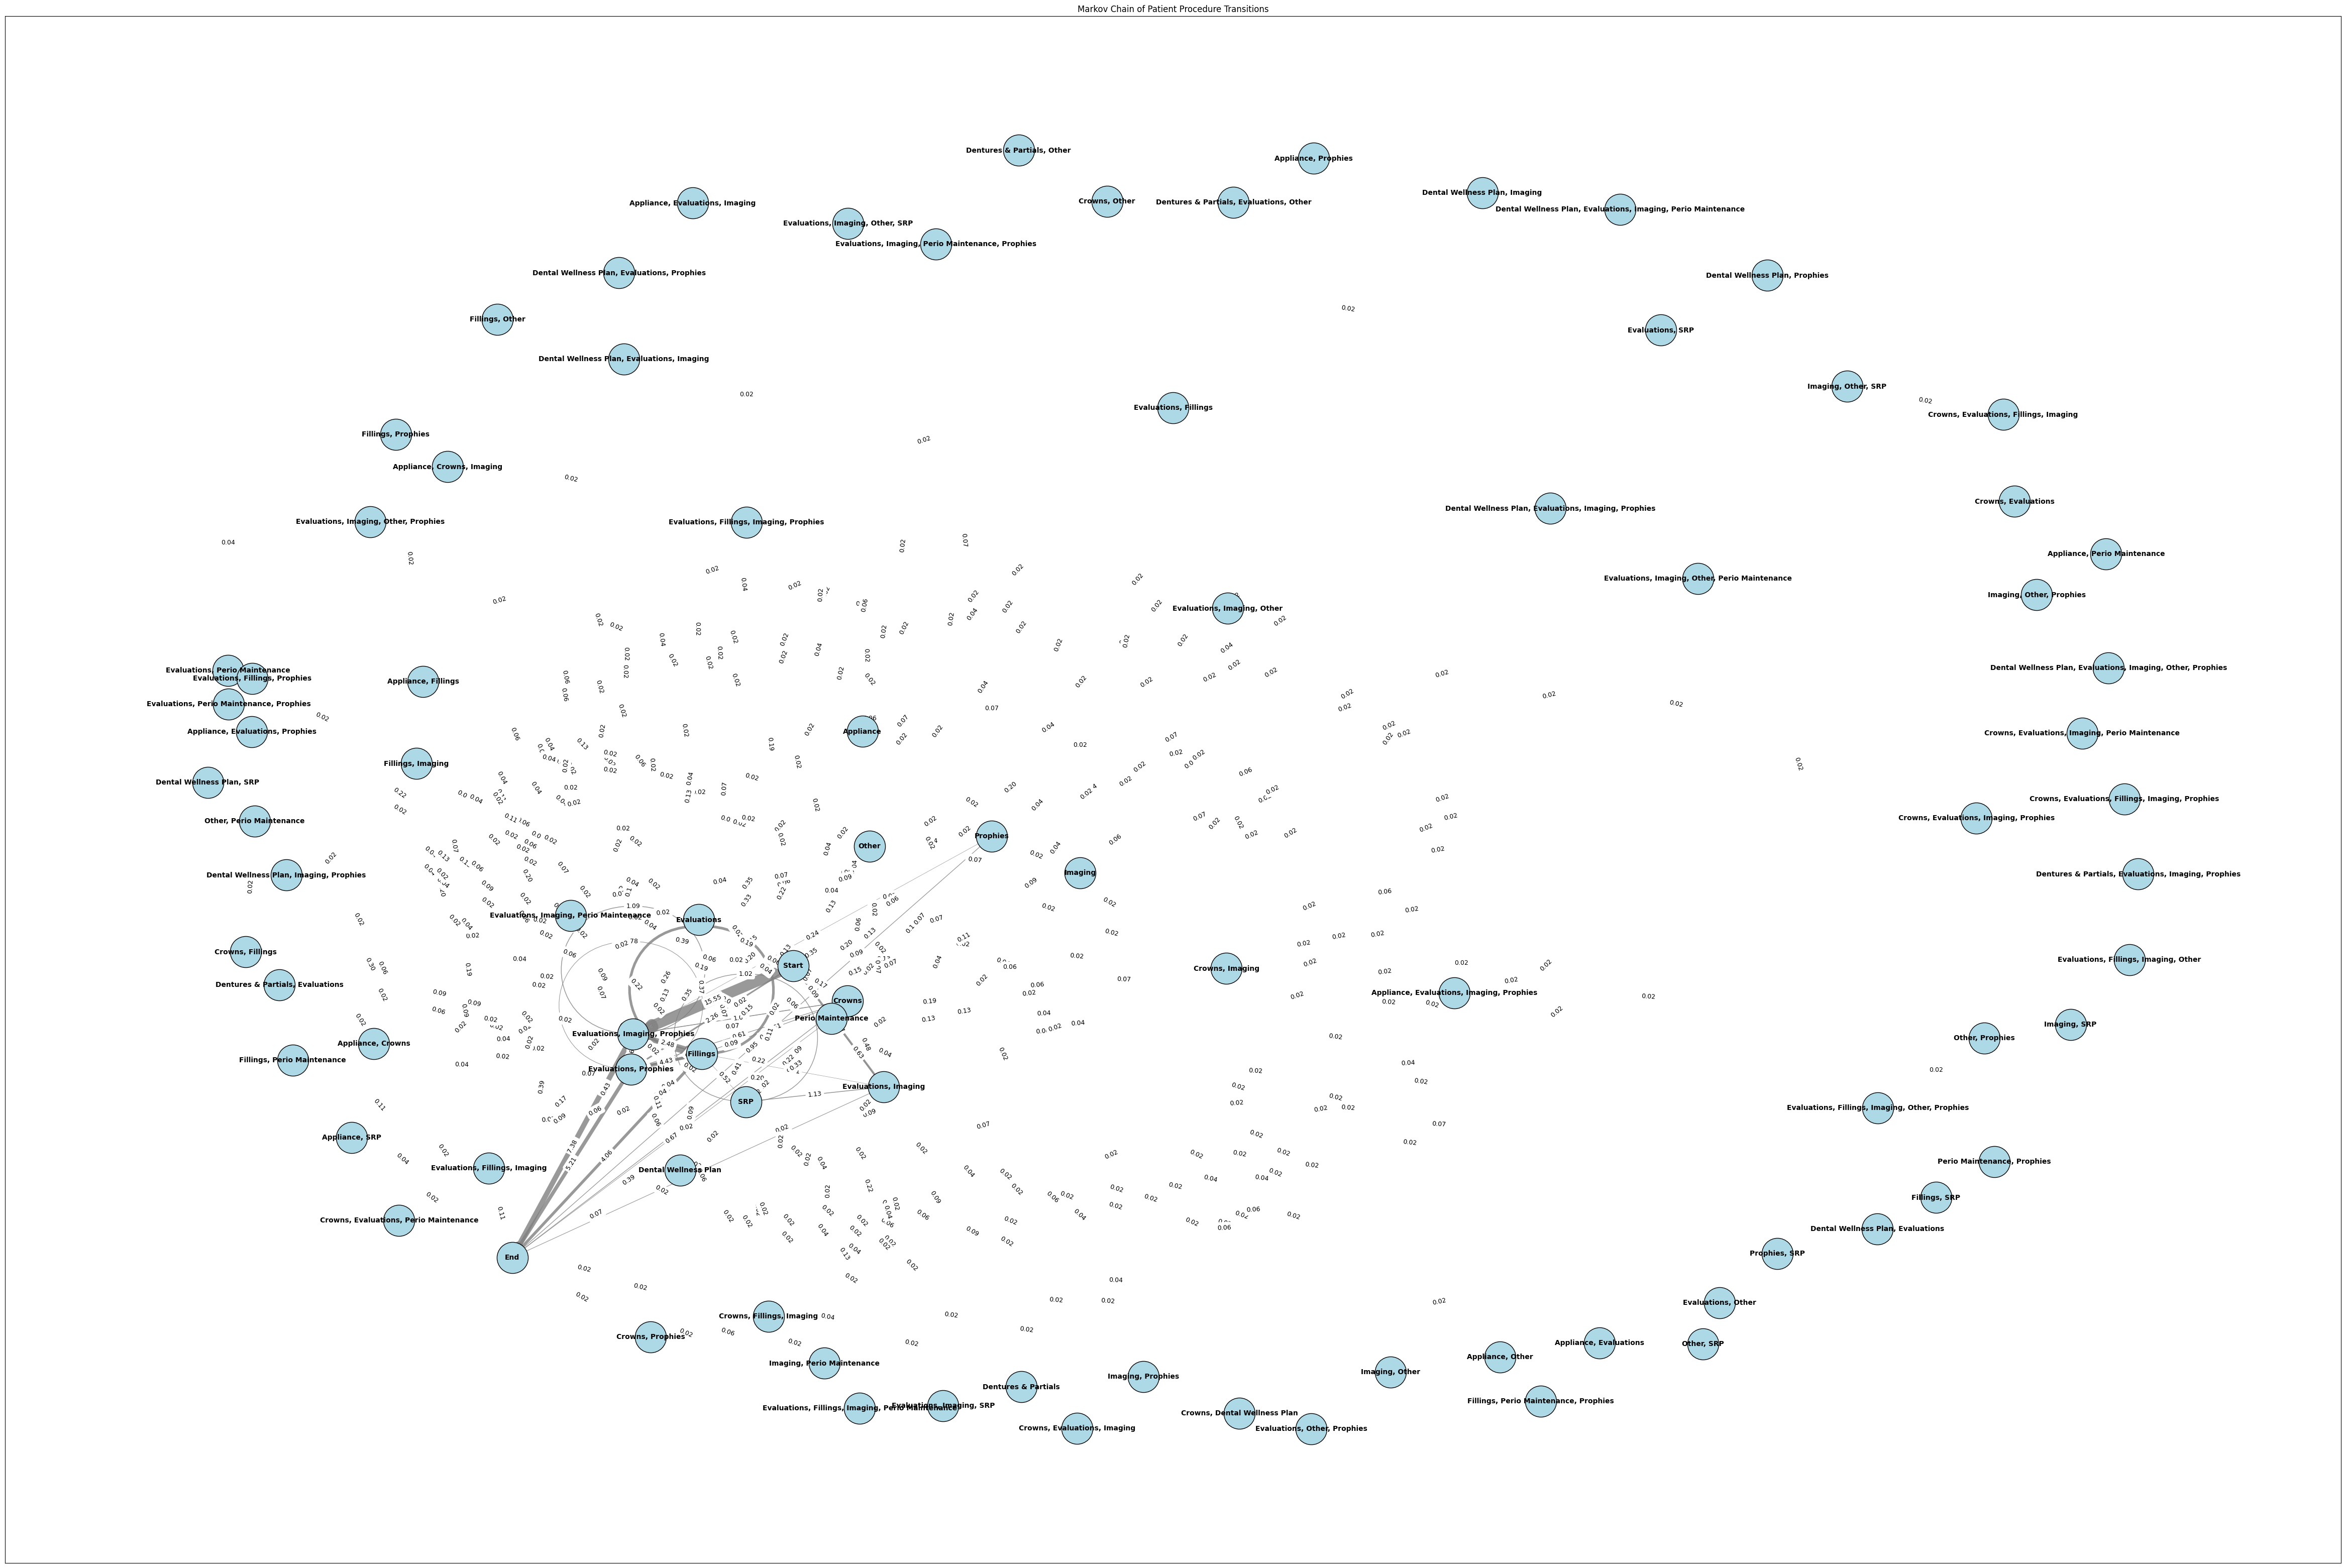

In [214]:

# Example usage (assuming df is your DataFrame with transition data)
import pandas as pd

df = graph_data.copy()  # Load your data
viz = MarkovChainVisualizer(df)
viz.draw_graph()
